In [1]:
import tensorflow as tf
import numpy as np
import scipy
from scipy import misc
import glob
from PIL import Image
import os
import matplotlib.pyplot as plt
import librosa
from keras import layers
from keras.layers import (Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, 
                          Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D)
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
import pydot
from IPython.display import SVG, Audio
from keras.layers import Dropout, GlobalAveragePooling2D
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.optimizers import Adam
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pydub import AudioSegment
import shutil
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2023-05-06 19:19:51.476722: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/chrispv/miniconda3/envs/tf-LSTM/lib/python3.8/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
2023-05-06 19:19:54.000113: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-06 19:19:54.022935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus

In [2]:
datasetPath = "../../datasets"

In [3]:
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'
genres = genres.split()

# Split Into Training and Testing
directory = f"{datasetPath}/spectrograms3sec/train/"
for g in genres:
  if len(os.listdir(os.path.join(f'{datasetPath}/spectrograms3sec/test/',f"{g}"))) == 0:
    filenames = os.listdir(os.path.join(directory,f"{g}"))
    random.shuffle(filenames)
    test_files = filenames[0:100]

    for f in test_files:

      shutil.move(directory + f"{g}"+ "/" + f,f"{datasetPath}/spectrograms3sec/test/" + f"{g}")

# Split Into Training and Validation
directory = f"{datasetPath}/spectrograms3sec/train/"
for g in genres:
  if len(os.listdir(os.path.join(f'{datasetPath}/spectrograms3sec/valid/',f"{g}"))) == 0:
    filenames = os.listdir(os.path.join(directory,f"{g}"))
    random.shuffle(filenames)
    test_files = filenames[0:100]

    for f in test_files:

      shutil.move(directory + f"{g}"+ "/" + f,f"{datasetPath}/spectrograms3sec/valid/" + f"{g}")

In [4]:
train_dir = f"{datasetPath}/spectrograms3sec/train/"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir,target_size=(26,65),color_mode="rgba",class_mode='categorical',batch_size=128)

test_dir = f"{datasetPath}/spectrograms3sec/test/"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir,target_size=(26,65),color_mode='rgba',class_mode='categorical',batch_size=128)

Found 8000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


In [5]:
validation_dir = f"{datasetPath}/spectrograms3sec/valid/"
vali_datagen = ImageDataGenerator(rescale=1./255)
vali_generator = vali_datagen.flow_from_directory(validation_dir,target_size=(26,65),color_mode='rgba',class_mode='categorical',batch_size=128)

def GenreModel(input_shape = (26,65, 4),classes=10):
  X_input = Input(input_shape)

  X = Conv2D(256, kernel_size=(3,3), activation='relu',padding="valid")(X_input)

  X = Conv2D(256, kernel_size=(3,3), activation='relu',padding="valid")(X)
  X = AveragePooling2D(pool_size=(3, 3), strides=(2,2),padding="same")(X)
  
  X = Conv2D(256, kernel_size=(3,3), activation='relu',padding="valid")(X)
  X = AveragePooling2D(pool_size=(3, 3), strides=(2,2),padding="same")(X)

  X = Conv2D(512, kernel_size=(4,4), activation='relu',padding="valid")(X)
  X = GlobalAveragePooling2D()(X)

  X = Dense(256, activation='relu')(X)
  X = Dense(128, activation='relu')(X)
  X = Dense(10, activation='softmax')(X)

  model = Model(inputs=X_input,outputs=X,name='GenreModel')

  return model

Found 1000 images belonging to 10 classes.


In [6]:
# checkpoint_path = "saved_cnn3/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                 save_weights_only=False,
#                                                 verbose=1)

model = GenreModel(input_shape=(26,65, 4), classes=10)
opt = Adam()
model.compile(optimizer = opt,loss='categorical_crossentropy',metrics=['accuracy'])

2023-05-06 19:19:55.062751: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-06 19:19:55.064263: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-06 19:19:55.064531: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-06 19:19:55.064790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0c:00.0/numa_nod

In [7]:
model.summary()

Model: "GenreModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 65, 4)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 63, 256)       9472      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 61, 256)       590080    
                                                                 
 average_pooling2d (AverageP  (None, 11, 31, 256)      0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 29, 256)        590080    
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 15, 256)       0         
 ePooling2D)                                            

In [9]:
fresh_model = True

from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint("saved/saved_cnn15_3.hdf5", save_best_only=True, monitor="val_loss", mode="min")
model_history = model.fit_generator(train_generator,epochs=140,validation_data=vali_generator, callbacks=[mc])

# if os.path.exists("../saved/saved_cnn15_3.h5"):
#     model_history = keras.models.load_model("../saved/saved_cnn15_3.h5")
# else:
#     model_history = model.fit_generator(train_generator,epochs=200,validation_data=vali_generator)
#     # model.save("../saved/saved_cnn14_3.h5")
#     fresh_model = True


/tmp/ipykernel_66926/809773661.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(train_generator,epochs=140,validation_data=vali_generator, callbacks=[mc])


Epoch 1/140


2023-05-06 19:20:20.497029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-05-06 19:20:34.739383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


63/63 [==============================] - 52s 544ms/step - loss: 2.0816 - accuracy: 0.2183 - val_loss: 1.8706 - val_accuracy: 0.3090
Epoch 2/140
63/63 [==============================] - 29s 457ms/step - loss: 1.8394 - accuracy: 0.3169 - val_loss: 1.7868 - val_accuracy: 0.3200
Epoch 3/140
63/63 [==============================] - 29s 459ms/step - loss: 1.7051 - accuracy: 0.3710 - val_loss: 1.5671 - val_accuracy: 0.4150
Epoch 4/140
63/63 [==============================] - 29s 457ms/step - loss: 1.5615 - accuracy: 0.4286 - val_loss: 1.4576 - val_accuracy: 0.4510
Epoch 5/140
63/63 [==============================] - 22s 343ms/step - loss: 1.4743 - accuracy: 0.4543 - val_loss: 1.4276 - val_accuracy: 0.4820
Epoch 6/140
63/63 [==============================] - 20s 313ms/step - loss: 1.4215 - accuracy: 0.4804 - val_loss: 1.3331 - val_accuracy: 0.5140
Epoch 7/140
63/63 [==============================] - 20s 313ms/step - loss: 1.3281 - accuracy: 0.5179 - val_loss: 1.3237 - val_accuracy: 0.5180
Epoc

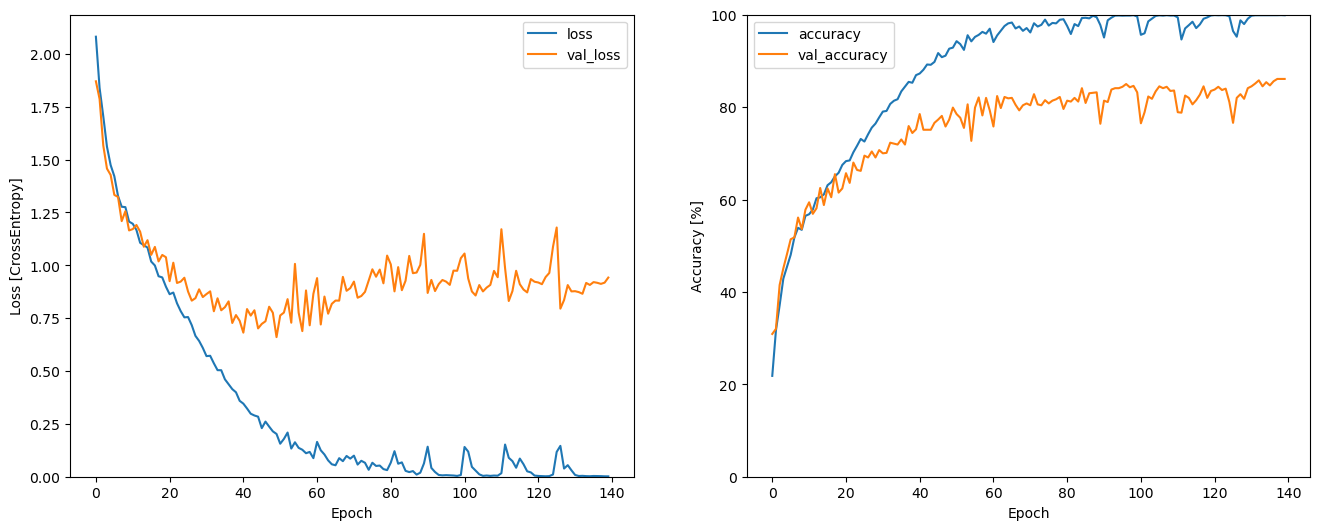

In [10]:
if fresh_model:
    metrics = model_history.history
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(model_history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')

    plt.subplot(1,2,2)
    plt.plot(model_history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')